In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix
from io import StringIO
from mst_clustering import MSTClustering
from amplpy import AMPL
# warnings.filterwarnings('ignore')

In [2]:
def ampl_solve(k,m,dist):
    #generates a "Kcluster.dat" with whe data for the LP problem for AMPL to solve
    output = open("Kcluster.dat", "w")
    output.write('param k:= '+ str(k) + ';')
    output.write('\n')
    output.write('param m:= '+ str(m) + ';')
    output.write('\n')
    output.write('param d: ')
    for i in range(m):output.write(str(i + 1) + ' ')
    output.write(':=')
    output.write('\n')
    for i in range(m):
        output.write(str(i + 1) + ' ')
        for j in range(m):
            output.write(str(dist[i][j]))
            if(j != m-1):output.write(' ')
        if(i != m-1):output.write('\n')
    output.write(';')
    output.write('\n')
    output.close()
    ampl = AMPL()
    ampl.read("Kcluster.mod")
    ampl.read_data("Kcluster.dat")
    ampl.option["solver"] = "highs"

    ampl.solve()

    #AMPL solution processing
    solution_input = ampl.get_variable("x").get_values().to_pandas().values.tolist()
    solution_input[0]
    sol = [0 for _ in range(m)]
    clusters = []
    for i in range(m):
        for j in range(m):
            if solution_input[i*m + j][0] == 1:
                if not (j) in clusters: clusters.append(j)
                sol[i] = clusters.index(j)
    return sol

def f_obj(dist,m,k,y_pred):
    k_sum = [0 for _ in range(k)]
    for i in range(m):
        dist_i = 0
        for j in range(m):
            if(y_pred[i] == y_pred[j]): dist_i = dist_i + dist[i][j]
        if(k_sum[y_pred[i]] == 0 or dist_i < k_sum[y_pred[i]]): k_sum[y_pred[i]] = dist_i
    
    sol = 0
    for elem in k_sum: sol = sol+elem
    return sol

In [39]:
#paremeter selection

k = 5
m = 300


Text(0, 0.5, 'y')

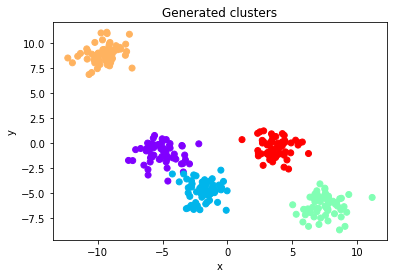

In [52]:
#generating points
random_state = 33
points, y_true = make_blobs(n_samples=m,centers = k, random_state=random_state)

#generate matrix distance
dist = [[math.sqrt((i[0]-j[0])**2+(i[1]-j[1])**2) for i in points] for j in points]


#print clusters
plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1],c = y_true,cmap='rainbow')
plt.title("Generated clusters")
plt.xlabel("x")
plt.ylabel("y")

C:\Users\moler\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\moler\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


The objective function value at the solution is: 362.8790628699255


Text(0, 0.5, 'y')

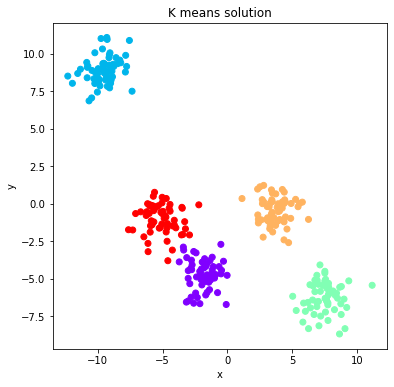

In [53]:
#Kmeans solution
random_state = 170
y_pred_kmeans = KMeans(n_clusters=k, random_state=random_state).fit_predict(points)


#print clusters
plt.figure(figsize=(6, 6))

print("The objective function value at the solution is: " + str(f_obj(dist,m,k,y_pred_kmeans)))
plt.scatter(points[:, 0], points[:, 1], c=y_pred_kmeans,cmap='rainbow')
plt.title("K means solution")
plt.xlabel("x")
plt.ylabel("y")

The objective function value at the solution is: 529.9580416161394


Text(0, 0.5, 'y')

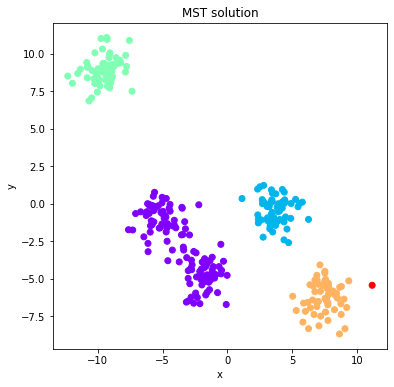

In [54]:
#MST solution
model = MSTClustering(cutoff=k-1)
y_pred_mst = model.fit_predict(points)

#print clusters
plt.figure(figsize=(6, 6))

print("The objective function value at the solution is: " + str(f_obj(dist,m,k,y_pred_mst)))
plt.scatter(points[:, 0], points[:, 1], c=y_pred_mst, cmap='rainbow');
plt.title("MST solution")
plt.xlabel("x")
plt.ylabel("y")

HiGHS 1.5.3:HiGHS 1.5.3: optimal solution; objective 362.7306418
8716 simplex iterations
1 branching nodes
 
The objective function value at the solution is: 362.7306418222894


Text(0, 0.5, 'y')

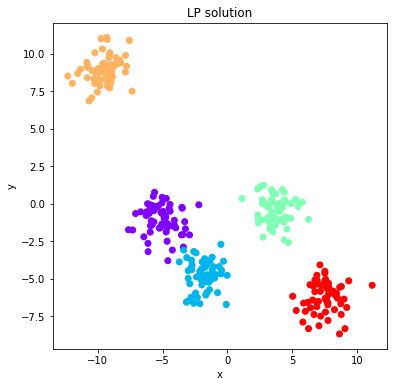

In [55]:
#AMPL solution


#We solve using ampl
y_pred_ampl = ampl_solve(k,m,dist)

            
#print clusters

print("The objective function value at the solution is: " + str(f_obj(dist,m,k,y_pred_ampl)))
plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1], c=y_pred_ampl,cmap='rainbow')
plt.title("LP solution")
plt.xlabel("x")
plt.ylabel("y")

In [65]:
#Loading of the multidimensional dataset
df = pd.read_csv('wine-clustering.csv')

#generate matrix distance
dist = scipy.spatial.distance.pdist(df, metric='euclidean')
dist = scipy.spatial.distance.squareform(dist, force='no', checks=True)
m = df.shape[0]
k = 5
df

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


C:\Users\moler\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\moler\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


The objective function value at the solution is: 10437.438788501566


Text(0, 0.5, 'Proline')

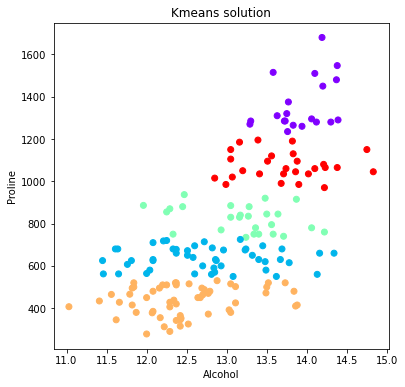

In [72]:
#Multidimensional dataset kmeans implementation

kmeans = KMeans(n_clusters=k, init='k-means++', random_state= 42)  
y_predict_kmeans= kmeans.fit_predict(df)

#print clusters
print("The objective function value at the solution is: " + str(f_obj(dist,m,k,y_predict_kmeans)))
plt.figure(figsize=(6, 6))
X = df.iloc[:,0]
y = df.iloc[:,-1]
plt.scatter(X,y,c=y_predict_kmeans,cmap = "rainbow");
plt.title("Kmeans solution")
plt.xlabel("Alcohol")
plt.ylabel("Proline")

The objective function value at the solution is: 38578.65862112732


Text(0, 0.5, 'Proline')

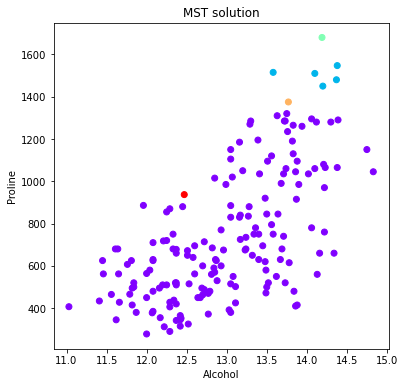

In [71]:
#Multidimensional dataset MST implementation

model = MSTClustering(cutoff=k-1)
y_predict_mst = model.fit_predict(df)

#print clusters
print("The objective function value at the solution is: " + str(f_obj(dist,m,k,y_predict_mst)))
plt.figure(figsize=(6, 6))
X = df.iloc[:,0]
y = df.iloc[:,-1]
plt.scatter(X,y,c=y_predict_mst,cmap = "rainbow");
plt.title("MST solution")
plt.xlabel("Alcohol")
plt.ylabel("Proline")

HiGHS 1.5.3:HiGHS 1.5.3: optimal solution; objective 10282.60781
6349 simplex iterations
1 branching nodes
 
The objective function value at the solution is: 10282.607809720206


Text(0, 0.5, 'Proline')

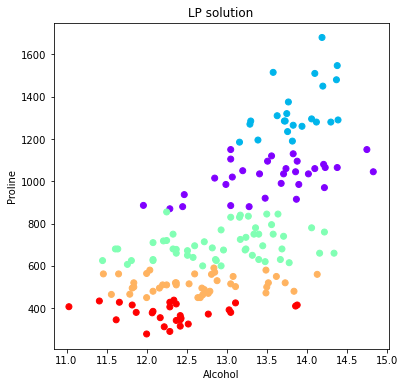

In [73]:
#Multidimensional dataset AMPL implementation


#We write the generated data in a .dat AMPL format.
y_predict_ampl = ampl_solve(k,m,dist)

            
#print clusters
print("The objective function value at the solution is: " + str(f_obj(dist,m,k,y_predict_ampl)))
plt.figure(figsize=(6, 6))
X = df.iloc[:,0]
y = df.iloc[:,-1]
plt.scatter(X,y,c=y_predict_ampl,cmap = "rainbow");
plt.title("LP solution")
plt.xlabel("Alcohol")
plt.ylabel("Proline")